In [8]:
from torchvision import transforms
from io import BytesIO
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import torch
import math

def JPEGcompression(image):
    QUALITY_FACTOR = 85

    outputIoStream = BytesIO()
    image.save(outputIoStream, "JPEG", quality=QUALITY_FACTOR)
    outputIoStream.seek(0)
    return Image.open(outputIoStream)

In [9]:
TRANSFORMS = {
    "original": transforms.Lambda(lambda x: x),
    "pad10": transforms.Pad(padding=30),
    "compress": transforms.Lambda(JPEGcompression),
    "grayscale": transforms.Grayscale(3),
    #"colorjitter": transforms.ColorJitter(brightness=0.1, hue=0.01, saturation=0.1, contrast=0.1),
    "randomaffine": transforms.RandomAffine(degrees=(0, 7), translate=(0, 0.1)),
}

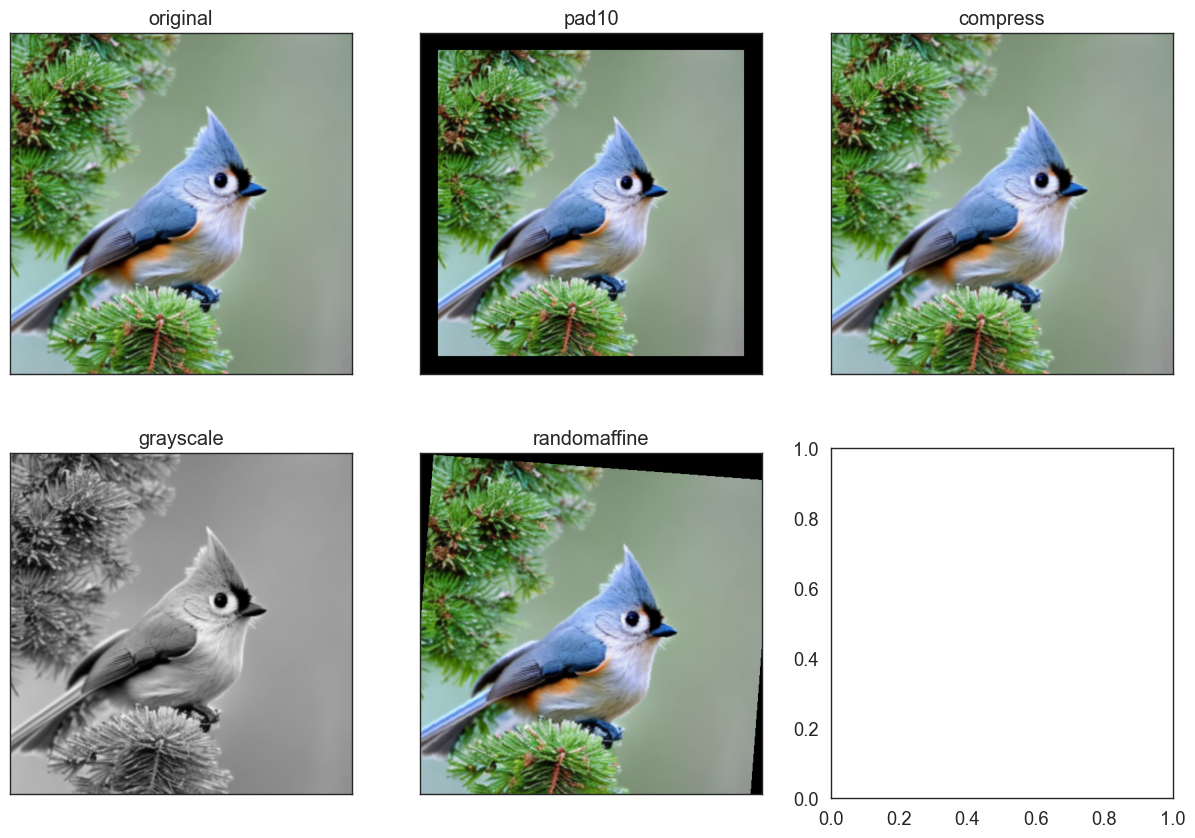

In [10]:
image = Image.open("bird.png").convert('RGB')
image = transforms.Resize((512, 512))(image)
sns.set_theme(style="white", context="paper", palette="muted", font_scale=1.5)
# plot each transform in subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, (name, transform) in enumerate(TRANSFORMS.items()):
    transform(image).save(f"{name}.png")
    axs[i // 3, i % 3].imshow(transform(image))
    axs[i // 3, i % 3].set_title(name)
    axs[i // 3, i % 3].set_yticklabels([])
    axs[i // 3, i % 3].set_xticklabels([])



In [11]:
def l2_distance(i1, i2):
    i1 = transforms.ToTensor()(i1)
    i2 = transforms.ToTensor()(i2)
    return torch.dist(i1, i2, p=2)

def l1_distance(i1, i2):
    i1 = transforms.ToTensor()(i1)
    i2 = transforms.ToTensor()(i2)
    return torch.dist(i1, i2, p=1)

def l0_distance(i1, i2):
    i1 = transforms.ToTensor()(i1)
    i2 = transforms.ToTensor()(i2)
    return torch.dist(i1, i2, p=0)

def linf_distance(i1, i2):
    i1 = transforms.ToTensor()(i1)
    i2 = transforms.ToTensor()(i2)
    return torch.dist(i1, i2, p=float("inf"))

def rand_perlin_2d(shape, res, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    
    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim = -1) % 1
    angles = 2*math.pi*torch.rand(res[0]+1, res[1]+1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim = -1)
    
    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    dot = lambda grad, shift: (torch.stack((grid[:shape[0],:shape[1],0] + shift[0], grid[:shape[0],:shape[1], 1] + shift[1]  ), dim = -1) * grad[:shape[0], :shape[1]]).sum(dim = -1)
    
    n00 = dot(tile_grads([0, -1], [0, -1]), [0,  0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1],[1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1,-1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])

def perlin_3_channels(shape, res):
    return torch.stack([rand_perlin_2d(shape, res), rand_perlin_2d(shape, res), torch.zeros(shape)])

NSP distance (l0): 598113.0
NSP distance (l1): 47221.859375
NSP distance (l2): 116.87137603759766
NSP distance (linf): 0.9921568632125854
SP Distance (l0): 518474.0
SP Distance (l1): 61482.765625
SP Distance (l2): 104.61832427978516
SP Distance (linf): 0.40392160415649414


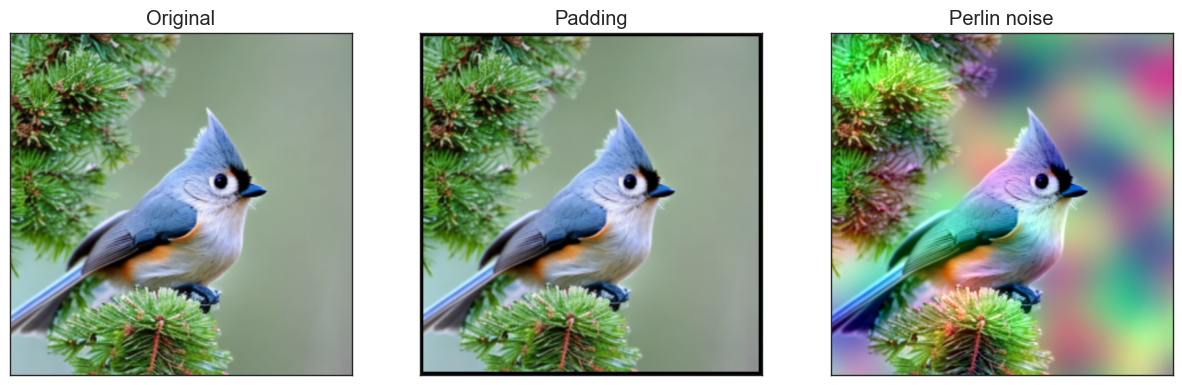

In [12]:
nsp = transforms.Compose([transforms.Pad(padding=5), transforms.Resize((512, 512))])

nsp_dist_0 = l0_distance(nsp(image), image)
nsp_dist_1 = l1_distance(nsp(image), image)
nsp_dist_2 = l2_distance(nsp(image), image)
nsp_dist_inf = linf_distance(nsp(image), image)
print(f"NSP distance (l0): {nsp_dist_0}")
print(f"NSP distance (l1): {nsp_dist_1}")
print(f"NSP distance (l2): {nsp_dist_2}")
print(f"NSP distance (linf): {nsp_dist_inf}")
# create image with pink line through the image with the same eucledian distance as the NSP transform
image2 = image.copy()
noise_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.clamp(x + 0.5 * perlin_3_channels((512, 512), (4,4)), min=0, max=1)),
   # transforms.Lambda(lambda x: torch.clamp(x + .15 * torch.randn((3, 256, 256)), min=0,max=1)),
    transforms.ToPILImage()
    ])
image2 = noise_trans(image2)
# totens = transforms.ToTensor()
# print(torch.max(torch.abs(totens(image) - totens(nsp(image)))))
# print(torch.max(torch.abs(totens(image) - totens(image2))))



pink_dist_0 = l0_distance(image2, image)
pink_dist_1 = l1_distance(image2, image)
pink_dist_2 = l2_distance(image2, image)
pink_dist_inf = linf_distance(image2, image)
print(f"SP Distance (l0): {pink_dist_0}")
print(f"SP Distance (l1): {pink_dist_1}")
print(f"SP Distance (l2): {pink_dist_2}")
print(f"SP Distance (linf): {pink_dist_inf}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].imshow(image)
axs[0].set_title("Original")
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])
axs[1].imshow(nsp(image))
axs[1].set_title("Padding")
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])
axs[2].imshow(image2)
axs[2].set_title("Perlin noise")
axs[2].set_yticklabels([])
axs[2].set_xticklabels([])
image.save("original.png")
nsp(image).save("padding.png")
image2.save("perlin.png")
plt.savefig("nsp.png", bbox_inches='tight', pad_inches=.1)


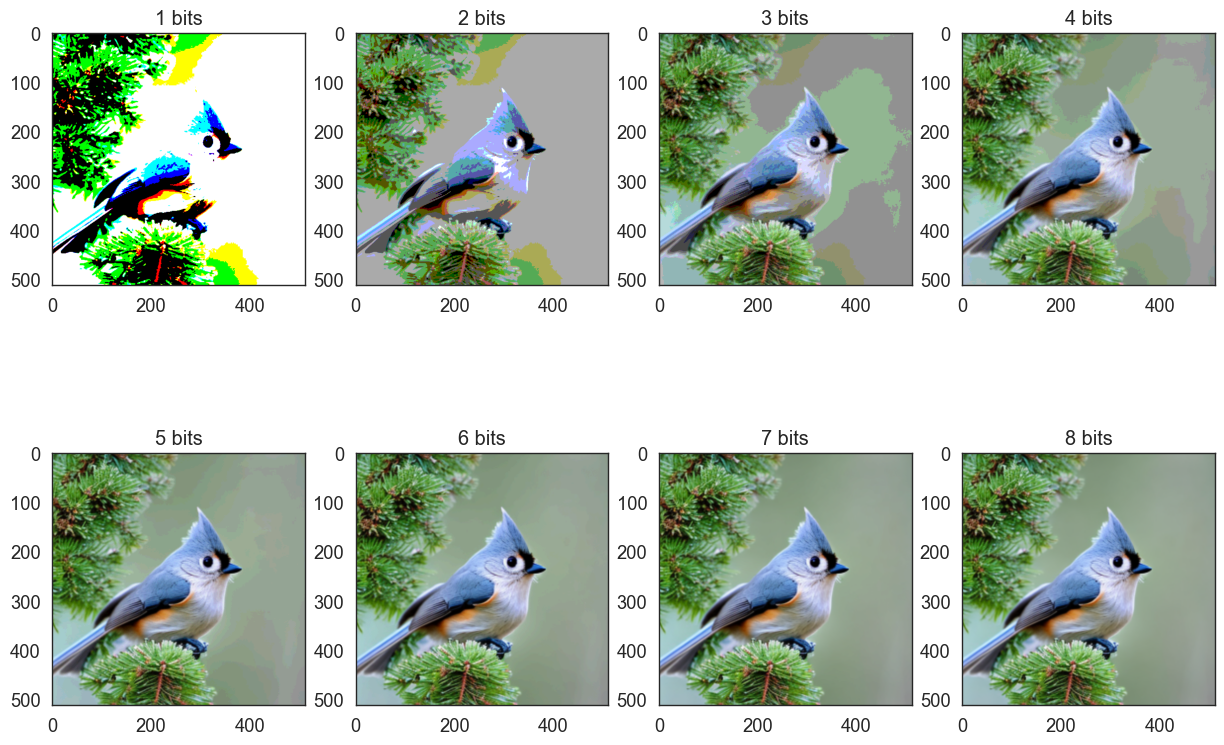

In [13]:
def squeeze(bits = 4):
    round_value = 2 ** bits-1
    def _squeeze(x):
        return torch.round(x * round_value) / round_value
    return _squeeze

image3 = image.copy()
bits = [8,7,6,5,4,3,2,1]
fig, axs = plt.subplots(2, 4, figsize=(15, 10))

def bitss(bits):
    x = 0
    res = 0
    while x < bits:
        res = res + 2 ** x
        x = x + 1
    return res

for b in bits:
    t = transforms.Compose([
        #transforms.Lambda(lambda x: (np.array(x) & bitss(b)) / (2 ** b)),
        transforms.ToTensor(),
        transforms.Lambda(squeeze(b)),
        transforms.ToPILImage()
    ])
    img = t(image3)
    img.save(f"bits_{b}.png")
    axs[(b-1)//4, (b-1)%4].imshow(img)
    axs[(b-1)//4, (b-1)%4].set_title(f"{b} bits")


In [14]:
def bits(bits):
    x = 0
    res = 0
    while x < bits:
        res = res + 2 ** x
        x = x + 1
    return res

x = (np.array(image) & bitss(3)) / (2 ** 3)
t = transforms.ToTensor()(x)

